In [1]:
import os
import time
import numpy as np
import h5py
import numpy.ma as ma
from jnormcorre.motion_correction import MotionCorrect
from ScanImageTiffReader import ScanImageTiffReader
from scipy.fft import fft2
import cv2
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.cluster.hierarchy import fcluster
from scipy.ndimage import convolve, shift
from tifffile import tifffile
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numba import jit, int64, float32, prange

In [2]:
def circshift(arr, shift, axes=None):
    """
    Circularly shift the elements of an array.

    Parameters:
    - arr (np.ndarray): Input array to be shifted.
    - shift (int, list, or np.ndarray): Number of places by which elements are shifted.
        - If an integer, the same shift is applied to all axes.
        - If a list or np.ndarray, each element specifies the shift for the corresponding axis.
    - axes (int, list of ints, or None, optional): Axis or axes along which to shift.
        - If None and shift is an integer, shift is applied to all axes.
        - If None and shift is a list/array, the length of shift must match the number of dimensions in arr.
        - Can be an integer or a list of integers corresponding to the axes.

    Returns:
    - np.ndarray: The shifted array.

    Raises:
    - ValueError: If the length of shift does not match the number of specified axes.
    """
    arr = np.asarray(arr)
    ndim = arr.ndim

    # Handle the axes parameter
    if axes is None:
        if isinstance(shift, (int, float)):
            axes = tuple(range(ndim))
            shift = (int(shift),) * ndim
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != ndim:
                raise ValueError("Length of shift array must match number of dimensions of arr.")
            axes = tuple(range(ndim))
    else:
        if isinstance(axes, int):
            axes = (axes,)
        elif isinstance(axes, (list, tuple, np.ndarray)):
            axes = tuple(axes)
        else:
            raise ValueError("axes must be an int or a list/tuple of ints.")

        if isinstance(shift, (int, float)):
            shift = (int(shift),) * len(axes)
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != len(axes):
                raise ValueError("Length of shift array must match number of specified axes.")

    # Apply the shifts
    for axis, s in zip(axes, shift):
        arr = np.roll(arr, shift=s, axis=axis)

    return arr
      
def dftups(inp, nor, noc, usfac, roff=0, coff=0):
    nr, nc = inp.shape
    # Compute kernels and obtain DFT by matrix products
    # kernc = np.exp(
    #     (-1j * 2 * np.pi / (nc * usfac))
    #     * (np.fft.ifftshift(np.arange(nc)) - np.floor(nc/2)).reshape(-1, 1)
    #     @ (np.arange(noc) - coff).reshape(1, -1)
    # )
    # kernr = np.exp(
    #     (-1j * 2 * np.pi / (nr * usfac))
    #     * (np.arange(nor).reshape(-1, 1) - roff)
    #     @ (np.fft.ifftshift(np.arange(nr)) - np.floor(nr/2)).reshape(1, -1)
    #     )
    # Compute kernc (column kernel)
    kernc = np.exp((-1j * 2 * np.pi / (nc * usfac)) *
                (np.fft.ifftshift(np.arange(nc)) - np.floor(nc / 2)).reshape(-1, 1) *
                (np.arange(noc) - coff))

    # Compute kernr (row kernel)
    kernr = np.exp((-1j * 2 * np.pi / (nr * usfac)) *
                (np.arange(nor).reshape(-1, 1) - roff) *
                (np.fft.ifftshift(np.arange(nr)) - np.floor(nr / 2)))
    out = kernr @ inp @ kernc
    return out
    
def dftregistration_clipped(buf1ft, buf2ft, usfac=1, clip=None):
    if clip is None:
        clip = [0, 0]
    elif isinstance(clip, (int, float)):
        clip = [clip, clip]

    # Compute error for no pixel shift
    if usfac == 0:
        CCmax = np.sum(buf1ft * np.conj(buf2ft))
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        output = [error, diffphase]
        return output, None

    # Whole-pixel shift - Compute crosscorrelation by an IFFT and locate the peak
    elif usfac == 1:
        m, n = buf1ft.shape
        md2 = m // 2
        nd2 = n // 2
        CC = np.fft.ifft2(buf1ft * np.conj(buf2ft))

        keep = np.ones(CC.shape, dtype=bool)
        keep[clip[0] // 2 + 1 : -clip[0] // 2, :] = False
        keep[:, clip[1] // 2 + 1 : -clip[1] // 2] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=0)
        loc1 = np.argmax(np.real(CC), axis=0)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        rloc = loc1[loc2]
        cloc = loc2
        CCmax = CC[rloc, cloc]
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2) / (m * n)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2) / (m * n)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))

        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m - 1  # Add the -1
        else:
            row_shift = rloc - 1      # Add the -1

        if cloc > nd2:
            col_shift = cloc - n - 1  # Add the -1
        else:
            col_shift = cloc - 1      # Add the -1

        output = [error, diffphase, row_shift, col_shift]
        return output, None

    # Partial-pixel shift
    else:
        m, n = buf1ft.shape
        mlarge = m * 2
        nlarge = n * 2
        CC = np.zeros((mlarge, nlarge), dtype=np.complex128)
        # CC[
        #     m - (m // 2) : m + (m // 2),
        #     n - (n // 2) : n + (n // 2),
        # ] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))
        CC[m//2:m//2 + m, n//2:n//2 + n] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))
        # Compute crosscorrelation and locate the peak
        CC = np.fft.ifft2(np.fft.ifftshift(CC))  # Calculate cross-correlation

        keep = np.ones(CC.shape, dtype=bool)
        keep[2 * clip[0] + 1 : -2 * clip[0], :] = False
        keep[:, 2 * clip[1] + 1 : -2 * clip[1]] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=1)
        loc1 = np.argmax(np.real(CC), axis=1)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        max_val = np.max(np.real(CC))
        rloc, cloc = np.unravel_index(np.argmax(np.real(CC)), CC.shape)
        CCmax = CC[rloc, cloc]

        # Obtain shift in original pixel grid from the position of the
        # crosscorrelation peak
        m, n = CC.shape
        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m
        else:
            row_shift = rloc
        if cloc > nd2:
            col_shift = cloc - n
        else:
            col_shift = cloc
        row_shift = row_shift / 2
        col_shift = col_shift / 2

        # If upsampling > 2, then refine estimate with matrix multiply DFT
        if usfac > 2:
            # Initial shift estimate in upsampled grid
            row_shift = np.round(row_shift * usfac, decimals=15) / usfac
            col_shift = np.round(col_shift * usfac, decimals=15) / usfac
            dftshift = np.fix(np.ceil(usfac * 1.5) / 2)  # Center of output array at dftshift+1
            # Matrix multiply DFT around the current shift estimate
            CC = np.conj(
                dftups(
                    buf2ft * np.conj(buf1ft),
                    np.ceil(usfac * 1.5),
                    np.ceil(usfac * 1.5),
                    usfac,
                    dftshift - row_shift * usfac,
                    dftshift - col_shift * usfac,
                )
            ) / (md2 * nd2 * usfac ** 2)
            # Locate maximum and map back to original pixel grid
            max1 = np.max(np.real(CC), axis=0) #<--------- was set to axis 0
            loc1 = np.argmax(np.real(CC), axis=0) #<--------- was set to axis 0
            max2 = np.max(max1)
            loc2 = np.argmax(max1)
            rloc = loc1[loc2]
            cloc = loc2
            CCmax = CC[rloc, cloc]
            rg00 = dftups(buf1ft * np.conj(buf1ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rf00 = dftups(buf2ft * np.conj(buf2ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rloc = rloc - dftshift
            cloc = cloc - dftshift
            row_shift = row_shift + rloc / usfac
            col_shift = col_shift + cloc / usfac

            # If upsampling = 2, no additional pixel shift refinement
        else:
            rg00 = np.sum(buf1ft * np.conj(buf1ft)) / m / n
            rf00 = np.sum(buf2ft * np.conj(buf2ft)) / m / n
        error = 1.0 - CCmax * np.conj(CCmax) / (rg00 * rf00)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        # If its only one row or column the shift along that dimension has no
        # effect. We set to zero.
        if md2 == 1:
            row_shift = 0
        if nd2 == 1:
            col_shift = 0
        output = [error, diffphase, row_shift, col_shift]

        # Compute registered version of buf2ft
        if usfac > 0:
            nr, nc = buf2ft.shape
            Nr = np.fft.ifftshift(np.arange(-np.fix(nr / 2), np.ceil(nr / 2)))
            Nc = np.fft.ifftshift(np.arange(-np.fix(nc / 2), np.ceil(nc / 2)))
            Nc, Nr = np.meshgrid(Nc, Nr)
            Greg = buf2ft * np.exp(
                1j * 2 * np.pi * (-row_shift * Nr / nr - col_shift * Nc / nc)
            )
            Greg = Greg * np.exp(1j * diffphase)
        elif usfac == 0:
            Greg = buf2ft * np.exp(1j * diffphase)
        else:
            Greg = None
    return output, Greg
    
def fast_xcorr2_nans(frame, template, shiftsCenter, dShift):
    dShift = round(dShift)  # Sanity check

    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

    tValid = np.roll(fValid, -shiftsCenter, axis=(0, 1)).astype(bool)

    F = frame[fValid]
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1

    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    # Print datatypes before the loop
    for drix, shift_x in enumerate(shifts):
        for dcix, shift_y in enumerate(shifts):
            shifted_tValid = np.roll(tValid, (-shift_x, -shift_y), axis=(0, 1))
            T = template[shifted_tValid]
            ssT = np.sum(T ** 2)
            
            if ssT > 0:  # Only calculate if ssT is greater than zero
                C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
            else:
                C[drix, dcix] = np.nan  # Handle cases where ssT is zero
            
    # plt.imshow(C)
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    I = np.unravel_index(np.nanargmax(C), C.shape)
    rr, cc = I
    R = maxval / ssF  # Correlation coefficient

    if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + [shifts[rr], shifts[cc]]

    if np.any(np.isnan(motion)):
        raise ValueError('Motion result contains NaN values')

    return motion, R

def matlab_round(x):
    """
    Replicates MATLAB's round function behavior
    
    In MATLAB:
    - round(4.5) = 5
    - round(-4.5) = -5
    """
    if x >= 0:
        return int(np.floor(x + 0.5))
    else:
        return int(np.ceil(x - 0.5))

In [6]:
M_mat = loadmat('/root/capsule/scratch/MandT_debug_177itr.mat')['M']
T_mat = loadmat('/root/capsule/scratch/MandT_debug_177itr.mat')['T']
clipShift = 10

In [7]:
check,_ = dftregistration_clipped(fft2(M_mat.astype(np.float32)), fft2(T_mat.astype(np.float32)), 4, clipShift)
print(check)

[array([[0.61949092]]), 5.856381287411878e-18, -3.75, 6.25]


In [30]:
buf1ft = fft2(M_mat.astype(np.float32))
buf2ft = fft2(T_mat.astype(np.float32))
usfac = 4
clip = [10, 10]


In [39]:
m, n = buf1ft.shape
mlarge = m * 2
nlarge = n * 2
CC = np.zeros((mlarge, nlarge), dtype=np.complex128)
# CC[
#     m - (m // 2) : m + (m // 2),
#     n - (n // 2) : n + (n // 2),
# ] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))
# Adjust slicing indices to match (41, 125)
row_start = m + 1 - (m // 2)
row_end = row_start + buf1ft.shape[0]  # Ensure it matches rows of buf1ft
col_start = n + 1 - (n // 2)
col_end = col_start + buf1ft.shape[1]  # Ensure it matches columns of buf2ft

# Perform fftshift and element-wise multiplication with conjugate
CC[row_start:row_end, col_start:col_end] = (
    np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))
)# Compute crosscorrelation and locate the peak
CC = np.fft.ifft2(np.fft.ifftshift(CC))  # Calculate cross-correlation

keep = np.ones(CC.shape, dtype=bool)
keep[2 * clip[0] + 1 : -2 * clip[0], :] = False
keep[:, 2 * clip[1] + 1 : -2 * clip[1]] = False
CC[~keep] = 0

max1 = np.max(np.real(CC), axis=0)
loc1 = np.argmax(np.real(CC), axis=0)
max2 = np.max(max1)
loc2 = np.argmax(max1)
max_val = np.max(np.real(CC))
rloc, cloc = np.unravel_index(np.argmax(np.real(CC)), CC.shape)
CCmax = CC[rloc, cloc]

# # Obtain shift in original pixel grid from the position of the
# # crosscorrelation peak
# m, n = CC.shape
# md2 = m // 2
# nd2 = n // 2
# if rloc > md2:
#     row_shift = rloc - m
# else:
#     row_shift = rloc
# if cloc > nd2:
#     col_shift = cloc - n
# else:
#     col_shift = cloc
# row_shift = row_shift / 2
# col_shift = col_shift / 2

# # If upsampling > 2, then refine estimate with matrix multiply DFT
# if usfac > 2:
#     # Initial shift estimate in upsampled grid
#     row_shift = np.round(row_shift * usfac, decimals=15) / usfac
#     col_shift = np.round(col_shift * usfac, decimals=15) / usfac
#     dftshift = np.fix(np.ceil(usfac * 1.5) / 2)  # Center of output array at dftshift+1
#     # Matrix multiply DFT around the current shift estimate
#     CC = np.conj(
#         dftups(
#             buf2ft * np.conj(buf1ft),
#             np.ceil(usfac * 1.5),
#             np.ceil(usfac * 1.5),
#             usfac,
#             dftshift - row_shift * usfac,
#             dftshift - col_shift * usfac,
#         )
#     ) / (md2 * nd2 * usfac ** 2)
#     # Locate maximum and map back to original pixel grid
#     max1 = np.max(np.real(CC), axis=0) #<--------- was set to axis 0
#     loc1 = np.argmax(np.real(CC), axis=0) #<--------- was set to axis 0
#     max2 = np.max(max1)
#     loc2 = np.argmax(max1)
#     rloc = loc1[loc2]
#     cloc = loc2
#     CCmax = CC[rloc, cloc]
#     rg00 = dftups(buf1ft * np.conj(buf1ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
#     rf00 = dftups(buf2ft * np.conj(buf2ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
#     rloc = rloc - dftshift
#     cloc = cloc - dftshift
#     row_shift = row_shift + rloc / usfac
#     col_shift = col_shift + cloc / usfac

#     # If upsampling = 2, no additional pixel shift refinement
# else:
#     rg00 = np.sum(buf1ft * np.conj(buf1ft)) / m / n
#     rf00 = np.sum(buf2ft * np.conj(buf2ft)) / m / n
# error = 1.0 - CCmax * np.conj(CCmax) / (rg00 * rf00)
# error = np.sqrt(np.abs(error))
# diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
# # If its only one row or column the shift along that dimension has no
# # effect. We set to zero.
# if md2 == 1:
#     row_shift = 0
# if nd2 == 1:
#     col_shift = 0
# output = [error, diffphase, row_shift, col_shift]

# # Compute registered version of buf2ft
# if usfac > 0:
#     nr, nc = buf2ft.shape
#     Nr = np.fft.ifftshift(np.arange(-np.fix(nr / 2), np.ceil(nr / 2)))
#     Nc = np.fft.ifftshift(np.arange(-np.fix(nc / 2), np.ceil(nc / 2)))
#     Nc, Nr = np.meshgrid(Nc, Nr)
#     Greg = buf2ft * np.exp(
#         1j * 2 * np.pi * (-row_shift * Nr / nr - col_shift * Nc / nc)
#     )
#     Greg = Greg * np.exp(1j * diffphase)
# elif usfac == 0:
#     Greg = buf2ft * np.exp(1j * diffphase)
# else:
#     Greg = None

In [40]:
CC_abs = np.abs(CC)
CC_real = np.real(CC)

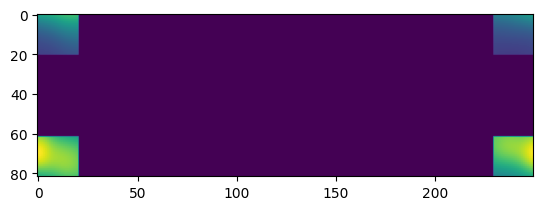

In [34]:
plt.imshow(CC_abs)

In [26]:
CC_abs[46, 88]

15948762446.16928

In [41]:
np.max(np.real(CC), axis=0)

array([4.36875938e+10, 4.44411022e+10, 4.47722036e+10, 4.48641261e+10,
       4.48547886e+10, 4.48140311e+10, 4.48096100e+10, 4.49441270e+10,
       4.52060218e+10, 4.55515914e+10, 4.59413958e+10, 4.63400048e+10,
       4.66928932e+10, 4.69371074e+10, 4.70410362e+10, 4.70026103e+10,
       4.68129547e+10, 4.64923110e+10, 4.60086764e+10, 4.54151894e+10,
       4.47603226e+10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [42]:
np.max(np.real(CC), axis=1)

array([3.73757648e+10, 3.45079867e+10, 3.15021409e+10, 2.85164406e+10,
       2.56293019e+10, 2.28266759e+10, 2.01053170e+10, 1.75280721e+10,
       1.56294396e+10, 1.45230332e+10, 1.36430876e+10, 1.27829633e+10,
       1.19427745e+10, 1.11110574e+10, 1.02822518e+10, 9.46115110e+09,
       8.65000413e+09, 7.84454263e+09, 7.04317544e+09, 6.24898948e+09,
       5.46250113e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [43]:
np.real(CC)

array([[3.35832135e+10, 3.39792872e+10, 3.42524915e+10, ...,
        3.15763050e+10, 3.23211672e+10, 3.30169579e+10],
       [3.11223640e+10, 3.14590365e+10, 3.17025481e+10, ...,
        2.94916381e+10, 3.00881020e+10, 3.06538414e+10],
       [2.85813637e+10, 2.88615585e+10, 2.90733273e+10, ...,
        2.72901249e+10, 2.77529718e+10, 2.82018765e+10],
       ...,
       [3.98764044e+10, 4.04457876e+10, 4.07686982e+10, ...,
        3.66071216e+10, 3.78549685e+10, 3.89898487e+10],
       [3.79421410e+10, 3.84558807e+10, 3.87704673e+10, ...,
        3.51122993e+10, 3.61834233e+10, 3.71653049e+10],
       [3.58527016e+10, 3.63085032e+10, 3.66065725e+10, ...,
        3.34448618e+10, 3.43480580e+10, 3.51830830e+10]])

In [44]:
from scipy.io import loadmat

CC_real = loadmat('/root/capsule/scratch/realCC.mat')['ans']


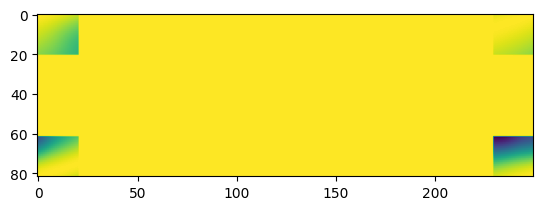

In [46]:
plt.imshow(np.real(CC) - CC_real)

In [47]:
np.real(CC) - CC_real

array([[ 2.16248418e+03, -1.07322342e+07, -4.33148628e+07, ...,
        -8.99647516e+07, -4.08724153e+07, -1.04282091e+07],
       [-9.15858290e+07, -1.63574465e+08, -2.56942590e+08, ...,
        -1.99490042e+04, -1.04531890e+07, -4.06801657e+07],
       [-3.38931573e+08, -4.65350806e+08, -6.12644424e+08, ...,
        -8.29052162e+07, -1.47817912e+08, -2.33038990e+08],
       ...,
       [-1.07726678e+09, -8.62772460e+08, -6.66526882e+08, ...,
        -1.77455211e+09, -1.53554802e+09, -1.30299004e+09],
       [-4.49936696e+08, -3.17770913e+08, -2.06499953e+08, ...,
        -9.38247906e+08, -7.62471487e+08, -5.99237128e+08],
       [-1.05506346e+08, -4.81846835e+07, -1.27182179e+07, ...,
        -3.90223597e+08, -2.78383991e+08, -1.82938189e+08]])